In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import os, sys

def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path

proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

import pandas as pd
import yaml
import torch
import collections

import warnings
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

warnings.filterwarnings("ignore")

from dqn.opinion_dynamics.utils.experiment import process_experiment


In [29]:
# experiment_sub_dir = "2025May02-101004_configs" # excellent run
experiment_sub_dir = "2025Jun01-133505_configs"

exp_path = os.path.join(r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results", experiment_sub_dir)
df = process_experiment(
    exp_path
)
df.columns


Index(['epoch_type', 'frame_stamp', 'greedy_epsilon', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_optim.args_.betas', 'sub_experiment_path', 'seed',
       'experiment_name'],
      dtype='object')

In [30]:
df

,epoch_type,frame_stamp,greedy_epsilon,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,...,episode_max_qs_mean,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_optim.args_.betas,sub_experiment_path,seed,experiment_name
0,training,200000,0.971500,-8.849446,-8.442856,-8.665713,-8.675687,0.055269,-8.228856,-7.888340,...,1.182018,1.265209,1.092500,48749.0,192.0,0 days 00:06:20.865089,"[0.9, 0.99]",D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.betas__0.9__0.99_
1,training,400000,0.942269,-9.114914,-8.326933,-8.660902,-8.672833,0.098207,-8.477972,-7.784868,...,-1.436924,-0.879696,1.710770,50000.0,200.0,0 days 00:06:44.732254,"[0.9, 0.99]",D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.betas__0.9__0.99_
2,training,600000,0.913038,-8.864969,-8.314915,-8.542339,-8.539840,0.093489,-8.262529,-7.775739,...,-2.013176,-1.335019,2.149020,50000.0,200.0,0 days 00:07:01.775035,"[0.9, 0.99]",D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.betas__0.9__0.99_
3,training,800000,0.883808,-8.936669,-8.174434,-8.464926,-8.440662,0.090779,-8.298715,-7.658992,...,-2.109791,-1.435770,2.248386,50000.0,200.0,0 days 00:07:06.922603,"[0.9, 0.99]",D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.betas__0.9__0.99_
4,training,1000000,0.854577,-10.811201,-8.074083,-8.513212,-8.402534,0.318450,-9.853844,-7.567962,...,-1.815083,-1.137521,2.094985,50000.0,200.0,0 days 00:07:07.838173,"[0.9, 0.99]",D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.betas__0.9__0.99_
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,validation,7200000,NaN,-7.923868,-7.923645,-7.923755,-7.923754,0.000049,-7.429817,-7.429615,...,-2.154783,-1.478590,2.222545,NaN,NaN,0 days 00:00:00.714560,"[0.5, 0.999]",D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0002_optim.args_.betas__0.5__0.999_
716,validation,7400000,NaN,-7.915839,-7.915633,-7.915733,-7.915737,0.000046,-7.422613,-7.422422,...,-2.134305,-1.452075,2.232189,NaN,NaN,0 days 00:00:00.720223,"[0.5, 0.999]",D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0002_optim.args_.betas__0.5__0.999_
717,validation,7600000,NaN,-7.914524,-7.914438,-7.914485,-7.914486,0.000021,-7.421649,-7.421571,...,-2.151716,-1.475655,2.217036,NaN,NaN,0 days 00:00:00.724970,"[0.5, 0.999]",D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0002_optim.args_.betas__0.5__0.999_
718,validation,7800000,NaN,-7.929762,-7.929340,-7.929505,-7.929476,0.000106,-7.433298,-7.432934,...,-2.158527,-1.460456,2.214044,NaN,NaN,0 days 00:00:00.723976,"[0.5, 0.999]",D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0002_optim.args_.betas__0.5__0.999_


In [31]:
# df[df['epoch_type'] == 'validation']
df[df['epoch_type'] == 'training']


,epoch_type,frame_stamp,greedy_epsilon,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,...,episode_max_qs_mean,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_optim.args_.betas,sub_experiment_path,seed,experiment_name
0,training,200000,0.971500,-8.849446,-8.442856,-8.665713,-8.675687,0.055269,-8.228856,-7.888340,...,1.182018,1.265209,1.092500,48749.0,192.0,0 days 00:06:20.865089,"[0.9, 0.99]",D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.betas__0.9__0.99_
1,training,400000,0.942269,-9.114914,-8.326933,-8.660902,-8.672833,0.098207,-8.477972,-7.784868,...,-1.436924,-0.879696,1.710770,50000.0,200.0,0 days 00:06:44.732254,"[0.9, 0.99]",D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.betas__0.9__0.99_
2,training,600000,0.913038,-8.864969,-8.314915,-8.542339,-8.539840,0.093489,-8.262529,-7.775739,...,-2.013176,-1.335019,2.149020,50000.0,200.0,0 days 00:07:01.775035,"[0.9, 0.99]",D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.betas__0.9__0.99_
3,training,800000,0.883808,-8.936669,-8.174434,-8.464926,-8.440662,0.090779,-8.298715,-7.658992,...,-2.109791,-1.435770,2.248386,50000.0,200.0,0 days 00:07:06.922603,"[0.9, 0.99]",D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.betas__0.9__0.99_
4,training,1000000,0.854577,-10.811201,-8.074083,-8.513212,-8.402534,0.318450,-9.853844,-7.567962,...,-1.815083,-1.137521,2.094985,50000.0,200.0,0 days 00:07:07.838173,"[0.9, 0.99]",D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.betas__0.9__0.99_
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,training,7200000,0.050000,-8.410372,-7.913824,-7.953711,-7.935878,0.045820,-7.821606,-7.420969,...,-2.146723,-1.401823,2.226603,50000.0,200.0,0 days 00:07:43.865075,"[0.5, 0.999]",D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0002_optim.args_.betas__0.5__0.999_
676,training,7400000,0.050000,-8.308118,-7.896430,-7.934519,-7.926690,0.031739,-7.743576,-7.405834,...,-2.146156,-1.400093,2.227663,50000.0,200.0,0 days 00:07:49.759927,"[0.5, 0.999]",D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0002_optim.args_.betas__0.5__0.999_
677,training,7600000,0.050000,-8.157341,-7.902794,-7.924230,-7.922931,0.013951,-7.624677,-7.411552,...,-2.141010,-1.437134,2.222099,50000.0,200.0,0 days 00:07:50.403375,"[0.5, 0.999]",D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0002_optim.args_.betas__0.5__0.999_
678,training,7800000,0.050000,-8.121088,-7.899428,-7.927039,-7.921124,0.026357,-7.591376,-7.407964,...,-2.141591,-1.373843,2.223173,50000.0,200.0,0 days 00:07:55.722927,"[0.5, 0.999]",D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0002_optim.args_.betas__0.5__0.999_


In [32]:
# Define hyperparameter columns
hyperparam_columns = [col for col in df.columns if "sub_exp_cfg" in col]

# Group by hyperparameter values and compute mean episode_rewards_mean
averaged_results = df.groupby(hyperparam_columns, as_index=False).agg({
    'episode_rewards_mean': 'mean',  # Averaging the performance metric
    'sub_experiment_path': 'first'   # Keep a reference to an experiment path
})

# Find the best hyperparameter set based on the highest mean reward
best_row = averaged_results.loc[averaged_results['episode_rewards_mean'].idxmax()]

# Print the best experiment path and hyperparameters
print(f"Best hyperparameters:\n{best_row[hyperparam_columns]}")
print(f"Best mean reward: {best_row['episode_rewards_mean']}")

Best hyperparameters:
sub_exp_cfg_optim.args_.betas    [0.95, 0.99]
Name: 2, dtype: object
Best mean reward: -8.016155194812633


In [33]:
averaged_results

,sub_exp_cfg_optim.args_.betas,episode_rewards_mean,sub_experiment_path
0,"[0.5, 0.999]",-8.042695,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
1,"[0.9, 0.99]",-8.065654,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
2,"[0.95, 0.99]",-8.016155,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...


In [34]:
# selected_metric = 'episode_rewards_mean'
# hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"

# # Filter for validation episodes
# validation_df = df[df['epoch_type'] == 'validation']

# # Get the unique sorted frame_stamp values
# unique_frames = np.sort(validation_df['frame_stamp'].unique())
# N = 1
# # Get all frame_stamp values after the first N unique ones
# filtered_frames = unique_frames[N:]

# # Filter the DataFrame to only include rows with these frame_stamp values
# filtered_df = validation_df[validation_df['frame_stamp'].isin(filtered_frames)]

# plt.figure(figsize=(10, 6))
# sns.lineplot(data=filtered_df, x='frame_stamp', y=selected_metric, hue=hue_col)
# plt.ylabel(selected_metric)
# plt.xlabel('Frame Stamp')
# plt.show()

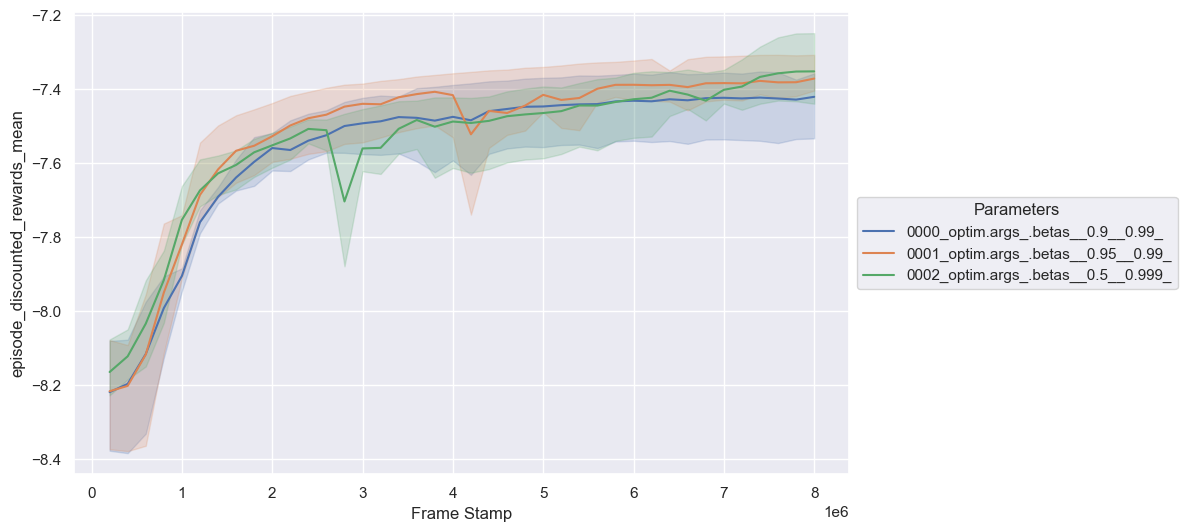

In [46]:

selected_metric = 'episode_discounted_rewards_mean'
# hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"
hue_col = "experiment_name"

# validation_df = df[df['epoch_type'] == 'validation']
validation_df = df[df['epoch_type'] == 'training']


# Create a new figure for each environment
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='frame_stamp', y=selected_metric, hue='model')
sns.lineplot(data=validation_df, 
             x='frame_stamp', 
             y=selected_metric, 
             hue=hue_col,
            #  units='seed', # Comment this to see mean + cf
            #  estimator=None, # Comment this to see mean + cf
             )

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')

# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
plt.show()

In [36]:
df.columns

Index(['epoch_type', 'frame_stamp', 'greedy_epsilon', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_optim.args_.betas', 'sub_experiment_path', 'seed',
       'experiment_name'],
      dtype='object')

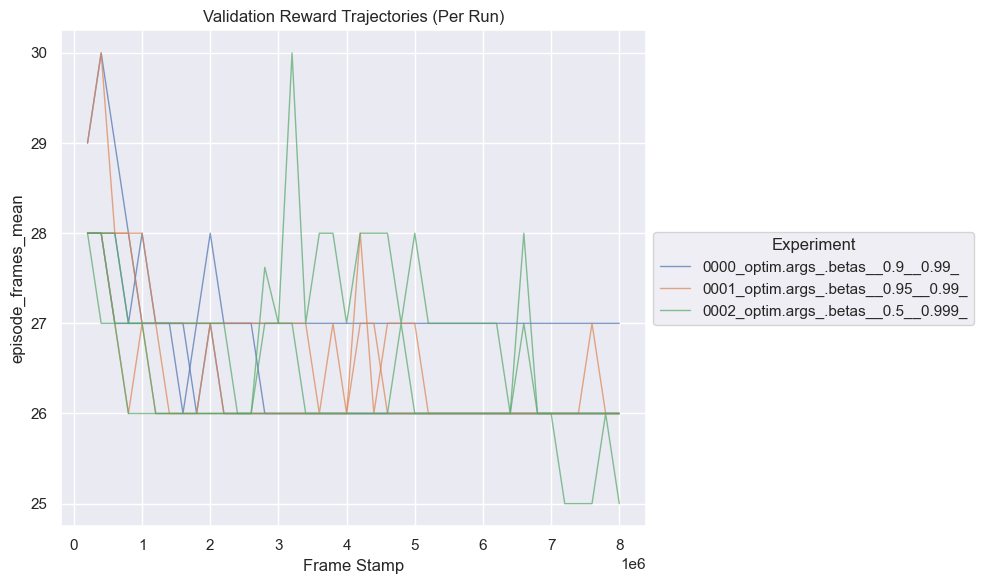

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_metric = 'episode_frames_mean'
hue_col = "experiment_name"  # or another distinguishing column like "sub_experiment_path"

validation_df = df[df['epoch_type'] == 'validation']

# Plot individual lines for each run
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=validation_df,
    x='frame_stamp',
    y=selected_metric,
    hue=hue_col,
    estimator=None,  # ← disables aggregation
    units='sub_experiment_path',  # ← groups lines by unique run
    lw=1,  # line width
    alpha=0.7  # transparency
)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.title('Validation Reward Trajectories (Per Run)')

# Move legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Experiment')
plt.tight_layout()
plt.show()


In [38]:
### Select data

experiment_columns = [
    'epoch_type', 'frame_stamp',
    'episode_rewards_mean', 'episode_frames_mean', 
    'episode_discounted_rewards_mean',
    'policy_trained_times', 'target_trained_times', 'epoch_time', 
       'seed', 'experiment_name', "sub_experiment_path"
]
hyperparam_columns = [
   col for col in df.columns if "sub_exp_cfg" in col
]

cols_of_interest = experiment_columns + hyperparam_columns

sub_df = df[cols_of_interest]
sub_df = sub_df[sub_df['epoch_type'] == 'validation']
sub_df = sub_df[sub_df['frame_stamp'] == sub_df['frame_stamp'].max()]

sub_df 


,epoch_type,frame_stamp,episode_rewards_mean,episode_frames_mean,episode_discounted_rewards_mean,policy_trained_times,target_trained_times,epoch_time,seed,experiment_name,sub_experiment_path,sub_exp_cfg_optim.args_.betas
79,validation,8000000,-7.850200,26.0,-7.364681,NaN,NaN,0 days 00:00:00.787041,0,0000_optim.args_.betas__0.9__0.99_,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,"[0.9, 0.99]"
159,validation,8000000,-7.833956,26.0,-7.351151,NaN,NaN,0 days 00:00:00.471663,1,0000_optim.args_.betas__0.9__0.99_,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,"[0.9, 0.99]"
239,validation,8000000,-8.050857,27.0,-7.532424,NaN,NaN,0 days 00:00:00.756293,2,0000_optim.args_.betas__0.9__0.99_,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,"[0.9, 0.99]"
319,validation,8000000,-7.885664,26.0,-7.396497,NaN,NaN,0 days 00:00:00.745817,0,0001_optim.args_.betas__0.95__0.99_,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,"[0.95, 0.99]"
399,validation,8000000,-7.780623,26.0,-7.304080,NaN,NaN,0 days 00:00:00.590212,1,0001_optim.args_.betas__0.95__0.99_,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,"[0.95, 0.99]"
479,validation,8000000,-7.883183,26.0,-7.392934,NaN,NaN,0 days 00:00:00.795087,2,0001_optim.args_.betas__0.95__0.99_,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,"[0.95, 0.99]"
559,validation,8000000,-7.842313,26.0,-7.359654,NaN,NaN,0 days 00:00:00.451721,0,0002_optim.args_.betas__0.5__0.999_,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,"[0.5, 0.999]"
639,validation,8000000,-7.698956,25.0,-7.240378,NaN,NaN,0 days 00:00:00.795773,1,0002_optim.args_.betas__0.5__0.999_,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,"[0.5, 0.999]"
719,validation,8000000,-7.900729,26.0,-7.409304,NaN,NaN,0 days 00:00:00.732378,2,0002_optim.args_.betas__0.5__0.999_,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,"[0.5, 0.999]"


In [39]:
# agg_cols = [col for col in sub_df.columns if "sub_exp_cfg_agent_params" in col]
# aggregated_df = (
#     sub_df.groupby(agg_cols)
#     .agg(episode_discounted_rewards_mean=("episode_discounted_rewards_mean", "mean"))
#     .reset_index()
# )
# aggregated_df

In [40]:
sub_df.columns

Index(['epoch_type', 'frame_stamp', 'episode_rewards_mean',
       'episode_frames_mean', 'episode_discounted_rewards_mean',
       'policy_trained_times', 'target_trained_times', 'epoch_time', 'seed',
       'experiment_name', 'sub_experiment_path',
       'sub_exp_cfg_optim.args_.betas'],
      dtype='object')

In [41]:
print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['sub_experiment_path'].values[0])



D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Jun01-133505_configs\0002_optim.args_.betas__0.5__0.999_\1


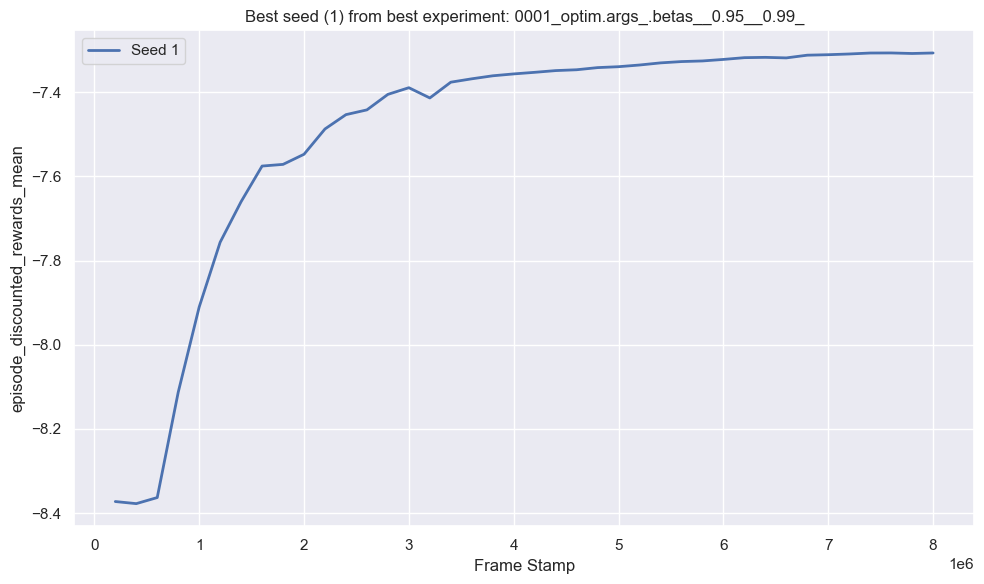

In [42]:
selected_metric = 'episode_discounted_rewards_mean'
hue_col = "experiment_name"

# Filter for training data only
training_df = df[df['epoch_type'] == 'training']

# Step 1: Find best experiment
experiment_means = training_df.groupby(hue_col)[selected_metric].mean()
best_experiment = experiment_means.idxmax()

# Step 2: Filter to that experiment
best_exp_df = training_df[training_df[hue_col] == best_experiment]

# Step 3: Find best seed within best experiment
best_seed = (
    best_exp_df.groupby('seed')[selected_metric]
    .mean()
    .idxmax()
)

# Step 4: Filter to best seed
best_seed_df = best_exp_df[best_exp_df['seed'] == best_seed]

# Step 5: Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=best_seed_df,
    x='frame_stamp',
    y=selected_metric,
    lw=2,
    label=f"Seed {best_seed}"
)

plt.title(f"Best seed ({best_seed}) from best experiment: {best_experiment}")
plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.legend()
plt.tight_layout()
plt.show()

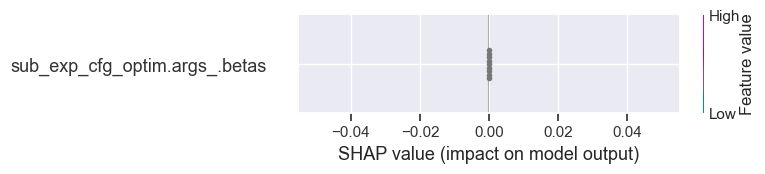

In [43]:
import shap
import xgboost
import pandas as pd


# Define the target metric and hyperparameter columns
target_metric = "episode_rewards_mean"  # Replace with actual metric column name
# Replace with actual hyperparameter column names

# Prepare data
X = sub_df[hyperparam_columns].apply(pd.to_numeric, errors='coerce')
y = sub_df[target_metric].fillna(3 * sub_df[target_metric].min())

# Train an XGBoost model to analyze feature importance
model = xgboost.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, y)

# SHAP analysis
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Summary plot (feature importance)
shap.summary_plot(shap_values, X)

In [44]:
hyperparam_columns

['sub_exp_cfg_optim.args_.betas']

In [45]:
import plotly.express as px

# Define readable names for selected hyperparams
readable_names = {
    hyperparam_columns[0]: "noise",
    hyperparam_columns[1]: "size"
}

# Rename columns in a copy of the dataframe
plot_df = sub_df.rename(columns=readable_names)

# Assign new column names
x_col = "noise"
y_col = "episode_rewards_mean"
facet_col = "size"

# Plot
fig = px.scatter(
    plot_df,
    x=x_col,
    y=y_col,
    color="experiment_name",  # Optional: color by experiment
    facet_col=facet_col,
    title="Episode Rewards vs. Noise Faceted by Size",
    height=600
)

fig.update_layout(showlegend=False)
fig.show()


IndexError: list index out of range